Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  

Merged Customer-Transactions Dat

C:\Users\Ezaz khan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ezaz khan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Ezaz khan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ezaz khan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL

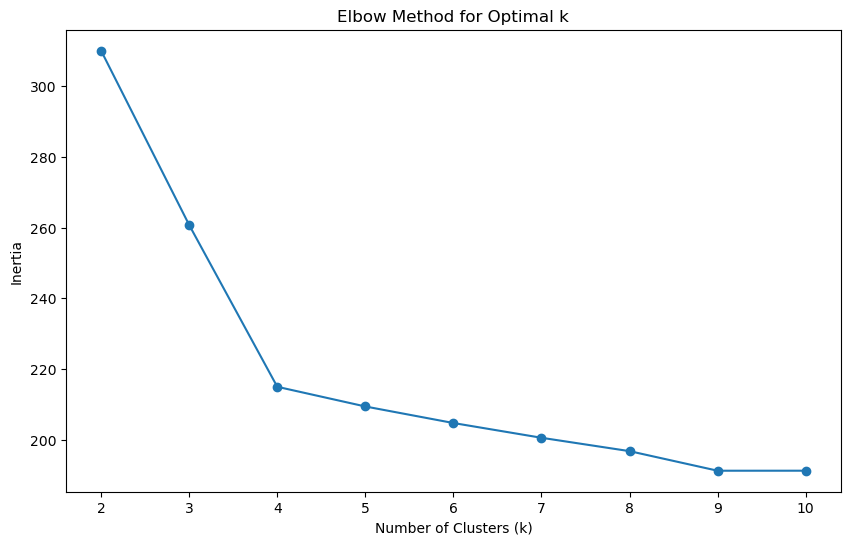

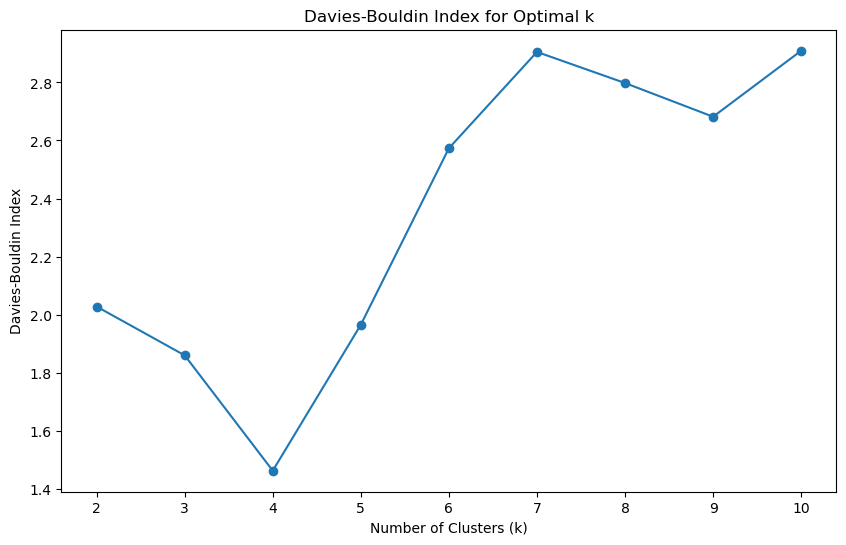

C:\Users\Ezaz khan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ezaz khan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Customer Profiles with Cluster Labels:
  CustomerID        CustomerName  SignupDate  TotalTransactions  TotalSpent  \
0      C0001    Lawrence Carroll  2022-07-10                0.4    0.308942   
1      C0002      Elizabeth Lutz  2022-02-13                0.3    0.168095   
2      C0003      Michael Rivera  2024-03-07                0.3    0.249541   
3      C0004  Kathleen Rodriguez  2022-10-09                0.7    0.497806   
4      C0005         Laura Weber  2022-08-15                0.2    0.184287   

   TotalQuantity  Region_Asia  Region_Europe  Region_North America  \
0       0.354839        False          False                 False   
1       0.290323         True          False                 False   
2       0.419355        False          False                 False   
3       0.709677        False          False                 False   
4       0.193548         True          False                 False   

   Region_South America  ...  FavoriteProduct_P078  FavoriteProd

In [5]:
# Step 1: Prepare the Data

# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Load the datasets
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Display the first few rows of each dataset
print("Customers Data:")
print(customers_df.head())

print("\nTransactions Data:")
print(transactions_df.head())

# Merge Customers and Transactions data
customer_transactions = pd.merge(customers_df, transactions_df, on="CustomerID")

# Display the merged data
print("\nMerged Customer-Transactions Data:")
print(customer_transactions.head())

# Ensure numeric columns are in the correct format
customer_transactions['TotalValue'] = pd.to_numeric(customer_transactions['TotalValue'], errors='coerce')
customer_transactions['Quantity'] = pd.to_numeric(customer_transactions['Quantity'], errors='coerce')

# Aggregate transaction data for each customer
customer_aggregated = customer_transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',  # Total number of transactions
    'TotalValue': 'sum',       # Total amount spent
    'Quantity': 'sum',         # Total quantity purchased
    'ProductID': lambda x: x.mode().iloc[0] if not x.mode().empty else None  # Most frequently purchased product
}).reset_index()

# Rename columns for clarity
customer_aggregated.rename(columns={
    'TransactionID': 'TotalTransactions',
    'TotalValue': 'TotalSpent',
    'Quantity': 'TotalQuantity',
    'ProductID': 'FavoriteProduct'
}, inplace=True)

# Display the aggregated data
print("\nAggregated Customer Data:")
print(customer_aggregated.head())

# Merge aggregated data with customer profiles
customer_profiles = pd.merge(customers_df, customer_aggregated, on="CustomerID")

# Display the final customer profiles
print("\nFinal Customer Profiles:")
print(customer_profiles.head())

# Step 2: Feature Engineering

# One-hot encode categorical variables
customer_profiles_encoded = pd.get_dummies(customer_profiles, columns=['Region', 'FavoriteProduct'])

# Normalize numerical features
scaler = MinMaxScaler()
numerical_features = ['TotalSpent', 'TotalTransactions', 'TotalQuantity']
customer_profiles_encoded[numerical_features] = scaler.fit_transform(customer_profiles_encoded[numerical_features])

# Display the normalized data
print("\nNormalized Customer Profiles:")
print(customer_profiles_encoded.head())

# Step 3: Perform Clustering

# Determine the optimal number of clusters using the Elbow Method and Davies-Bouldin Index
db_scores = []
inertia_values = []

# Test different values of k (from 2 to 10)
for k in range(2, 11):
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_profiles_encoded.drop(columns=['CustomerID', 'CustomerName', 'SignupDate']))
    
    # Calculate the Davies-Bouldin Index
    db_index = davies_bouldin_score(customer_profiles_encoded.drop(columns=['CustomerID', 'CustomerName', 'SignupDate']), kmeans.labels_)
    db_scores.append(db_index)
    
    # Store the inertia (within-cluster sum of squares)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia_values, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

# Plot the Davies-Bouldin Index
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), db_scores, marker='o')
plt.title("Davies-Bouldin Index for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.show()

# Choose the optimal number of clusters (e.g., k=4)
optimal_k = 4

# Perform K-Means clustering with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(customer_profiles_encoded.drop(columns=['CustomerID', 'CustomerName', 'SignupDate']))

# Add the cluster labels to the customer profiles
customer_profiles_encoded['Cluster'] = kmeans.labels_

# Display the customer profiles with cluster labels
print("\nCustomer Profiles with Cluster Labels:")
print(customer_profiles_encoded.head())

# Step 4: Analyze and Visualize Clusters

# Calculate the mean values of numeric features for each cluster
numeric_columns = ['TotalSpent', 'TotalTransactions', 'TotalQuantity']
cluster_analysis_numeric = customer_profiles_encoded.groupby('Cluster')[numeric_columns].mean()

# For non-numeric columns, handle the one-hot encoded columns (e.g., FavoriteProduct)
# First, get all columns related to FavoriteProduct (these should be one-hot encoded columns)
favorite_product_columns = [col for col in customer_profiles_encoded.columns if 'FavoriteProduct' in col]

# Find the mode (most frequent value) for each one-hot encoded column
cluster_analysis_non_numeric = customer_profiles_encoded.groupby('Cluster')[favorite_product_columns].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Combine both numeric and non-numeric analyses
cluster_analysis = pd.concat([cluster_analysis_numeric, cluster_analysis_non_numeric], axis=1)

# Display the cluster analysis
print("\nCluster Analysis:")
print(cluster_analysis)



# Step 5: Save the Results

# Save the customer profiles with cluster labels to a CSV file
customer_profiles_encoded.to_csv('Clustered_Customers.csv', index=False)

# Save the cluster analysis to a CSV file
cluster_analysis.to_csv('Cluster_Analysis.csv')

print("\nClustering results saved to 'Clustered_Customers.csv' and 'Cluster_Analysis.csv'.")
